In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read dataset
dataset = pd.read_csv("../data/data.csv")

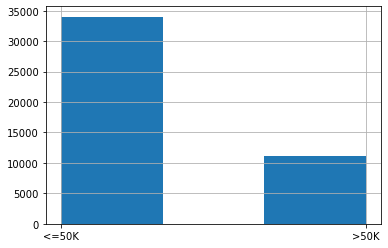

In [3]:
targets = dataset['income']
# Plot income distribution
targets.hist(bins=len(targets.unique()) + 1)

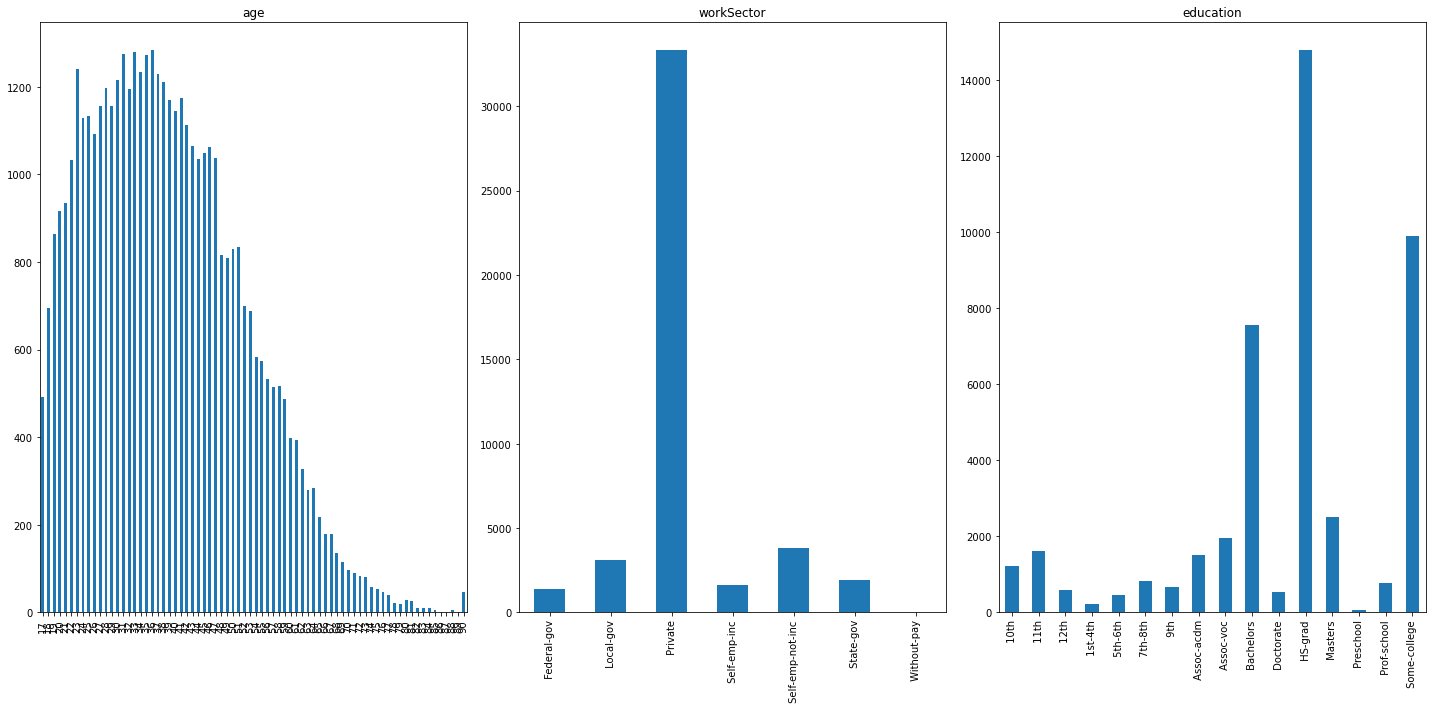

In [4]:
fig, axes = plt.subplots(ncols=3, figsize=(20,10))
for col, ax in zip(dataset[:3], axes):
    dataset[col].value_counts().sort_index().plot.bar(ax=ax, title=col)

plt.tight_layout()    
plt.show()


# pd.plotting.scatter_matrix(dataset)

In [5]:
all_features = dataset.drop(['income'], axis=1)
print(all_features.columns)

Index(['age', 'workSector', 'education', 'educationNum', 'statusMarriage',
       'career', 'relationship', 'race', 'sex', 'gainedCapital', 'lostCapital',
       'hoursPerWeek', 'country'],
      dtype='object')


In [10]:
# Replace non-numeric values using specific maps
import json

numeric_columns = dataset.select_dtypes('number').columns
not_numeric_cols = [x for x in dataset if x not in numeric_columns]

print("Numeric columns {}".format(list(numeric_columns)))
print("Not Numeric columns {}".format(not_numeric_cols))

dataset_numeric = dataset.copy()
mappings = {}
for it in not_numeric_cols:
    labels = dataset[it].unique().tolist()
    #labels = [x.strip().lower() for x in labels]
    mapping = dict(zip(labels, range(len(labels))))
    mappings[it] = mapping
    dataset_numeric.replace({it:mapping}, inplace=True)

print(dataset_numeric[not_numeric_cols])
print(mappings)

with open("../model/mapping.json", 'w') as f:
    json.dump(mappings, f)

Numeric columns ['age', 'educationNum', 'gainedCapital', 'lostCapital', 'hoursPerWeek']
Not Numeric columns ['workSector', 'education', 'statusMarriage', 'career', 'relationship', 'race', 'sex', 'country', 'income']
       workSector  education  statusMarriage  career  relationship  race  sex  \
0               0          0               0       0             0     0    0   
1               1          0               1       1             1     0    0   
2               2          1               2       2             0     0    0   
3               2          2               1       2             1     1    0   
4               2          0               1       3             2     1    1   
...           ...        ...             ...     ...           ...   ...  ...   
45217           2          0               0       3             3     0    0   
45218           2          0               2       3             0     0    1   
45219           2          0               1       3   

In [11]:
from sklearn.model_selection import train_test_split

Y = dataset_numeric.income.values
X = dataset_numeric.drop(['income'], axis=1)

# Now split to train/test with 80% training data, and 20% test data.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Train Features Size:", X_train.shape)
print("Test Features Size:", X_test.shape)
print("Train Labels Size:", Y_train.shape)
print("Test Labels Size:", Y_test.shape)

Train Features Size: (36177, 13)
Test Features Size: (9045, 13)
Train Labels Size: (36177,)
Test Labels Size: (9045,)


In [12]:
# Build and train model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.optimizers import Adam

def NN_model(learning_rate, input_dim):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, activation='softmax'))
    Adam(lr=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

learning_rate = 0.01
model = NN_model(learning_rate, X_train.shape[1])
print(model.summary())

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=128, verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                448       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 34        
Total params: 1,010
Trainable params: 1,010
Non-trainable params: 0
_________________________________________________________________
None
Train on 36177 samples, validate on 9045 samples
Epoch 1/10
36177/36177 - 1s - loss: 0.5861 - acc: 0.7720 - val_loss: 0.4449 - val_acc: 0.7923
Epoch 2/10
36177/36177 - 0s - loss: 0.4575 - acc: 0.7864 - val_loss: 0.4383 - val_acc: 0.7812
Epoch 3/10
36177/36177 - 0s - loss: 0.4690 - acc: 0.7864 - val_loss: 0.4296 - val_acc: 0.7705
Epoch 4/10
36177/36177 - 0s - loss: 0.4035 - a

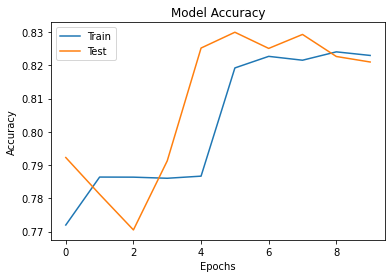

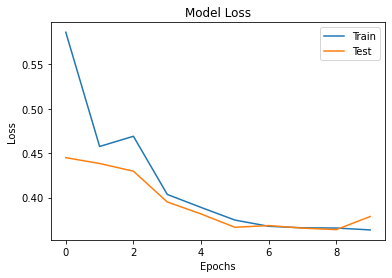

Model Accracy: 82.10060807075732 %
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      6745
           1       0.78      0.42      0.54      2300

    accuracy                           0.82      9045
   macro avg       0.80      0.69      0.72      9045
weighted avg       0.81      0.82      0.80      9045



In [13]:
# Plot loss & accuracy for train and validation data
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

# Plot the Loss function vs. number of Epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

from sklearn.metrics import classification_report, accuracy_score

predictions = np.argmax(model.predict(X_test), axis=1)
model_accuracy = accuracy_score(Y_test, predictions)*100
print("Model Accracy:", model_accuracy,"%")
print(classification_report(Y_test, predictions))

In [ ]:
from tensorflow.keras.models import load_model

# Save model
model.save("../ckpts/model_v2/my_net_save.h5")

# Load saved model
reload_tf_mmodel = load_model("../ckpts/model_v2/my_net_save.h5")